In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torchvision
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import tensorflow as tf

2023-04-20 03:52:59.581363: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 03:53:00.859497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
torch.cuda.set_device(1)
print(torch.cuda.current_device())
device = torch.cuda.current_device()

True
2
1


In [3]:
df = pd.read_csv('IDRiD/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv',na_values="n/a", usecols = [i for i in range(3)])
len(df), df

(413,
     Image name  Retinopathy grade  Risk of macular edema 
 0    IDRiD_001                  3                       2
 1    IDRiD_002                  3                       2
 2    IDRiD_003                  2                       2
 3    IDRiD_004                  3                       2
 4    IDRiD_005                  4                       0
 ..         ...                ...                     ...
 408  IDRiD_409                  2                       1
 409  IDRiD_410                  2                       0
 410  IDRiD_411                  2                       0
 411  IDRiD_412                  2                       0
 412  IDRiD_413                  2                       0
 
 [413 rows x 3 columns])

In [4]:
df['Retinopathy grade'].value_counts()

2    136
0    134
3     74
4     49
1     20
Name: Retinopathy grade, dtype: int64

In [5]:
base_dir = 'IDRiD/B. Disease Grading/1. Original Images/a. Training Set'
len(os.listdir(base_dir)), os.listdir(base_dir)[:10]

(413,
 ['IDRiD_051.jpg',
  'IDRiD_124.jpg',
  'IDRiD_228.jpg',
  'IDRiD_285.jpg',
  'IDRiD_192.jpg',
  'IDRiD_370.jpg',
  'IDRiD_140.jpg',
  'IDRiD_238.jpg',
  'IDRiD_272.jpg',
  'IDRiD_011.jpg'])

In [6]:
def image_preprocessing(img):
    img = img.astype(np.uint8)
    #CLAHE on L channel
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    clahe = cv2.createCLAHE(clipLimit=2,tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    new_img = cv2.cvtColor(lab, cv2.COLOR_Lab2BGR)
    
    return new_img

In [7]:
from skimage import exposure
def clahe_preprocessing(img):
    img_np = img.numpy()  # convert to numpy array
    img_np = np.transpose(img_np, (1, 2, 0))  # rearrange dimensions from (C, H, W) to (H, W, C)
    img_clahe = exposure.equalize_adapthist(img_np, clip_limit=0.01, nbins=256)
    img_clahe = np.transpose(img_clahe, (2, 0, 1))  # rearrange dimensions from (H, W, C) to (C, H, W)
    img_tensor_clahe = torch.from_numpy(img_clahe)  # convert back to tensor
    return img_tensor_clahe

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+'.jpg')
        #print(os.path.isdir(self.img_dir))
        #print(os.listdir(self.img_dir))
        image = read_image(img_path)/255.
        image = clahe_preprocessing(image)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [9]:
idrid_train = CustomImageDataset(csv_file='IDRiD/train.csv',
                             img_dir='IDRiD/B. Disease Grading/1. Original Images/a. Training Set',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.RandomHorizontalFlip(p=0.3),
                                                           transforms.RandomVerticalFlip(p=0.3),
                                                           transforms.ColorJitter(brightness=0.1,
                                                                                  contrast=0.1,
                                                                                  saturation=0.01,
                                                                                  hue=0.01),
                                                           transforms.ToTensor(),
                                                           
                                                           transforms.Resize((512,512)),
                                                           
                                                          ])
                            )
idrid_val = CustomImageDataset(csv_file='IDRiD/val.csv',
                             img_dir='IDRiD/B. Disease Grading/1. Original Images/a. Training Set',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.ToTensor(),
                                                           
                                                           transforms.Resize((512,512))
                                                          ])
                            )
idrid_test = CustomImageDataset(csv_file='IDRiD/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv',
                             img_dir='IDRiD/B. Disease Grading/1. Original Images/b. Testing Set',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.ToTensor(),
                                                           
                                                           transforms.Resize((512,512))
                                                          ])
                            )

In [10]:
batch_size=32
train_dataloader = DataLoader(idrid_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(idrid_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(idrid_test, batch_size=batch_size, shuffle=True)

/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Feature batch shape: torch.Size([32, 3, 512, 512])
Labels batch shape: torch.Size([32])


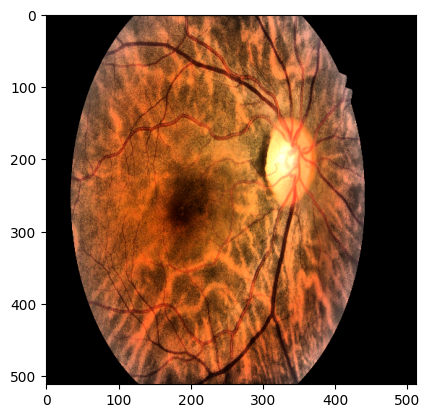

Label: 0


In [12]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
npimg = img.numpy()
label = train_labels[0]
plt.imshow(np.transpose(npimg,(1,2,0)))
plt.show()
print(f"Label: {label}")

# MODEL DEFINITION

In [11]:
df = pd.read_csv('IDRiD/train.csv',na_values="n/a", usecols = [i for i in range(3)])
len(df), df

(330,
     Image name  Retinopathy grade  Risk of macular edema 
 0    IDRiD_312                  0                       0
 1    IDRiD_177                  0                       0
 2    IDRiD_149                  0                       0
 3    IDRiD_359                  0                       0
 4    IDRiD_146                  0                       0
 ..         ...                ...                     ...
 325  IDRiD_240                  4                       2
 326  IDRiD_033                  4                       2
 327  IDRiD_394                  4                       2
 328  IDRiD_390                  4                       2
 329  IDRiD_010                  4                       1
 
 [330 rows x 3 columns])

In [12]:
df['Retinopathy grade'].value_counts()

2    109
0    107
3     59
4     39
1     16
Name: Retinopathy grade, dtype: int64

In [13]:
nSamples = [107, 16, 109, 59, 39]
norm_weights = [1 - (x / sum(nSamples)) for x in nSamples]
print(norm_weights)
model_weights = torch.tensor(norm_weights)
print(model_weights)

[0.6757575757575758, 0.9515151515151515, 0.6696969696969697, 0.8212121212121212, 0.8818181818181818]
tensor([0.6758, 0.9515, 0.6697, 0.8212, 0.8818])


In [14]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class TransferInceptionV3(nn.Module):
    def __init__(self, num_classes=5, dropout=0.5):
        super(TransferInceptionV3, self).__init__()
        self.features = models.inception_v3(pretrained=True)
        self.features.aux_logits = False 
        for param in self.features.parameters():
            param.requires_grad = True
        self.fc1 = nn.Linear(1000, 256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        
    def forward(self, x):
        x = self.features(x)
        #x = x.logits
        #x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.dropout(self.leaky_relu(self.fc2(x)))
        x = self.fc3(x)
        return x


model = TransferInceptionV3()
model = model.to(torch.cuda.current_device())
#Unweighted
#criterion = nn.CrossEntropyLoss()
#Weighted
criterion = nn.CrossEntropyLoss(weight=model_weights.to(torch.cuda.current_device()))
optimizer = optim.Adam(model.parameters(), lr=0.001)
#device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


/home/mainuser/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mainuser/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import timeit
# Train the model
num_epochs = 50

best_val_loss = float('inf')
All_train_loss = []
All_val_loss = []

for epoch in range(num_epochs):
    start_time = timeit.default_timer()
    
    # Train the model on the training set
    total_train_loss = 0
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        #take argmax of the logits before computing the loss?
        outputs = model(images)
        #logits = outputs.logits
        loss = criterion(outputs, labels)
        total_train_loss += loss * images.shape[0]
        print(loss)
        # Backward and optimize
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the validation set
    print("VALIDATING")
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        correct = 0
        total = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            #logits = outputs.logits
            #take argmax of the logits before computing the loss 
            #outputs = outputs.softmax(dim=1)
            val_loss = criterion(outputs, labels)
            print(val_loss)
            total_val_loss += val_loss.item() * images.shape[0]
            #take argmax of the logits before computing the loss 
            predicted = torch.argmax(outputs, 1) #did torch.argmax instead of torch.max
            total += labels.size(0)
            print((predicted == labels).sum())
            correct += (predicted == labels).sum()
    avg_train_loss = total_train_loss/330
    avg_val_loss = total_val_loss/83
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    All_train_loss.append(avg_train_loss.cpu())
    All_val_loss.append(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print("Updating best model...")
        torch.save(model.state_dict(), 'idrid_best_clahe.pt')
    
    elapsed = timeit.default_timer() - start_time
    print("Epoch took", str(elapsed//60), "minutes")
        
torch.save(model.state_dict(), 'idrid_last_clahe.pt')

/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(1.6034, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.5747, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.5988, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.4871, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.4578, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.4550, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.3702, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.3128, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.6896, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.9100, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.2815, device='cuda:1', grad_fn=<NllLossBackward0>)
VALIDATING
tensor(1.3497, device='cuda:1')
tensor(10, device='cuda:1')
tensor(1.2792, device='cuda:1')
tensor(13, device='cuda:1')
tensor(1.4412, device='cuda:1')
tensor(4, device='cuda:1')
Epoch 1/50: Train Loss = 1.5379, Val Loss = 1.3435
Updating best model...
Epoch took 38.0 minutes
tensor(1.4875, device='cuda:1', grad_fn=<NllLossBack

In [ ]:
#print(All_val_loss)
All_val_loss = list(All_val_loss)
All_train_loss = list(All_train_loss)
with open("idrid_train_loss_clahe.txt", 'w') as f:
    for val in All_train_loss:
        v = val.detach().numpy()
        f.write(str(v))
        f.write("\n")
        
with open("idrid_val_loss_clahe.txt", 'w') as f:
    for val in All_val_loss:
        
        v = val
        f.write(str(v))
        f.write("\n")

In [21]:
### Testing             
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

model = TransferInceptionV3()
model.load_state_dict(torch.load('idrid_best_clahe.pt'))
model = model.to(torch.cuda.current_device())

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        y_true.extend(labels.cpu())
        y_pred.extend(predicted.cpu())

# Compute the accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test F1 Score: {f1:.4f}')

print(f'kappa score: {kappa:4f}')

/home/mainuser/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mainuser/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, d

Test Accuracy: 0.5534
Test F1 Score: 0.5253
kappa score: 0.381139


In [22]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[29  0  5  0  0]
 [ 4  0  1  0  0]
 [ 8  0 17  7  0]
 [ 2  0  5  5  7]
 [ 0  0  5  2  6]]
              precision    recall  f1-score   support

           0      0.674     0.853     0.753        34
           1      0.000     0.000     0.000         5
           2      0.515     0.531     0.523        32
           3      0.357     0.263     0.303        19
           4      0.462     0.462     0.462        13

    accuracy                          0.553       103
   macro avg      0.402     0.422     0.408       103
weighted avg      0.507     0.553     0.525       103



/home/mainuser/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mainuser/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mainuser/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
for i in range(len(y_true)):
    print(y_true[i], y_pred[i])

tensor(2) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(2)
tensor(2) tensor(2)
tensor(2) tensor(2)
tensor(4) tensor(0)
tensor(2) tensor(0)
tensor(0) tensor(0)
tensor(2) tensor(2)
tensor(3) tensor(2)
tensor(0) tensor(2)
tensor(2) tensor(2)
tensor(3) tensor(2)
tensor(0) tensor(0)
tensor(4) tensor(2)
tensor(1) tensor(2)
tensor(2) tensor(0)
tensor(4) tensor(2)
tensor(0) tensor(2)
tensor(0) tensor(0)
tensor(3) tensor(2)
tensor(0) tensor(0)
tensor(0) tensor(2)
tensor(2) tensor(2)
tensor(3) tensor(2)
tensor(2) tensor(0)
tensor(2) tensor(2)
tensor(2) tensor(2)
tensor(4) tensor(2)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(2)
tensor(4) tensor(2)
tensor(3) tensor(2)
tensor(2) tensor(0)
tensor(3) tensor(2)
tensor(0) tensor(0)
tensor(2) tensor(0)
tensor(2) tensor(2)
tensor(0) tensor(0)
tensor(4) tensor(2)
tensor(4) tensor(0)
tensor(4) tensor(2)
tensor(3) tensor(0)
tensor(3) tensor(2)
tensor(0) tensor(0)
tensor(3) tensor(2)


# PLOTTING

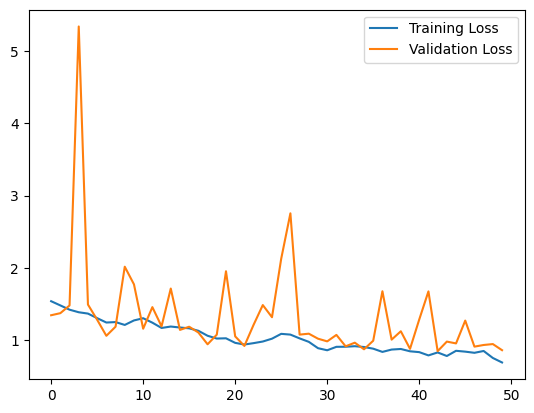

In [20]:
train_loss_plot = []
for value in All_train_loss:
    v = value.detach().numpy()
    train_loss_plot.append(v)
plt.plot(train_loss_plot, label='Training Loss')
plt.plot(All_val_loss,label='Validation Loss')
plt.legend()
plt.show
plt.savefig('CLAHE_trainLossValLoss.png')

# Things to DO

In [25]:
#Performance comparison without training the entire architecture - done
#Doing weighted cross entropy - done
#Play with augmentation techniques
#Decaying rate of LR